# **Project Overview**
This project analyzes Lending Club loan data to forecast default risk through logistic regression analysis.

I conducted data preprocessing and exploration, established a baseline model, and applied undersampling to tackle class imbalance.

The objective was to pinpoint key financial and behavioral factors that forecast default and to assess the model using metrics focused on recall.

## **Importing the Libraries and Loading the Data**


In [25]:
# Mounting Google Drive due to Colab being used for development
from google.colab import drive
drive.mount('/content/drive')

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling + Evaluation
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Aesthetic settings
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/bank-loan-risk-analysis/data/bank_loan.csv', low_memory=False)
print("Initial shape of dataset:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial shape of dataset: (2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

## **Data Cleaning and Feature Engineering**

In [26]:
# Keep only loans with known outcomes
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

# Create binary target: 1 = defaulted (Charged Off), 0 = repaid
df['loan_default'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# Select relevant features
selected = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
    'emp_length', 'home_ownership', 'annual_inc', 'purpose',
    'dti', 'delinq_2yrs', 'fico_range_high', 'open_acc',
    'revol_util', 'total_acc', 'loan_default'
]
df = df[selected].copy()

# Clean 'term' (convert "36 months" into 36)
df['term'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

# Clean 'emp_length' to numeric
def clean_emp(val):
    val = str(val)
    if 'n' in val.lower(): return np.nan
    if '<' in val: return 0
    if '10+' in val: return 10
    try: return float(val.strip().split()[0])
    except: return np.nan

df['emp_length'] = df['emp_length'].apply(clean_emp)

# Convert revolving utilization to float
df['revol_util'] = df['revol_util'].astype(str).str.replace('%', '').astype(float)

# Drop rows with missing values
df.dropna(inplace=True)
print("After cleaning:", df.shape)

After cleaning: (1265976, 16)


## **Exploratory Data Analysis (EDA)**

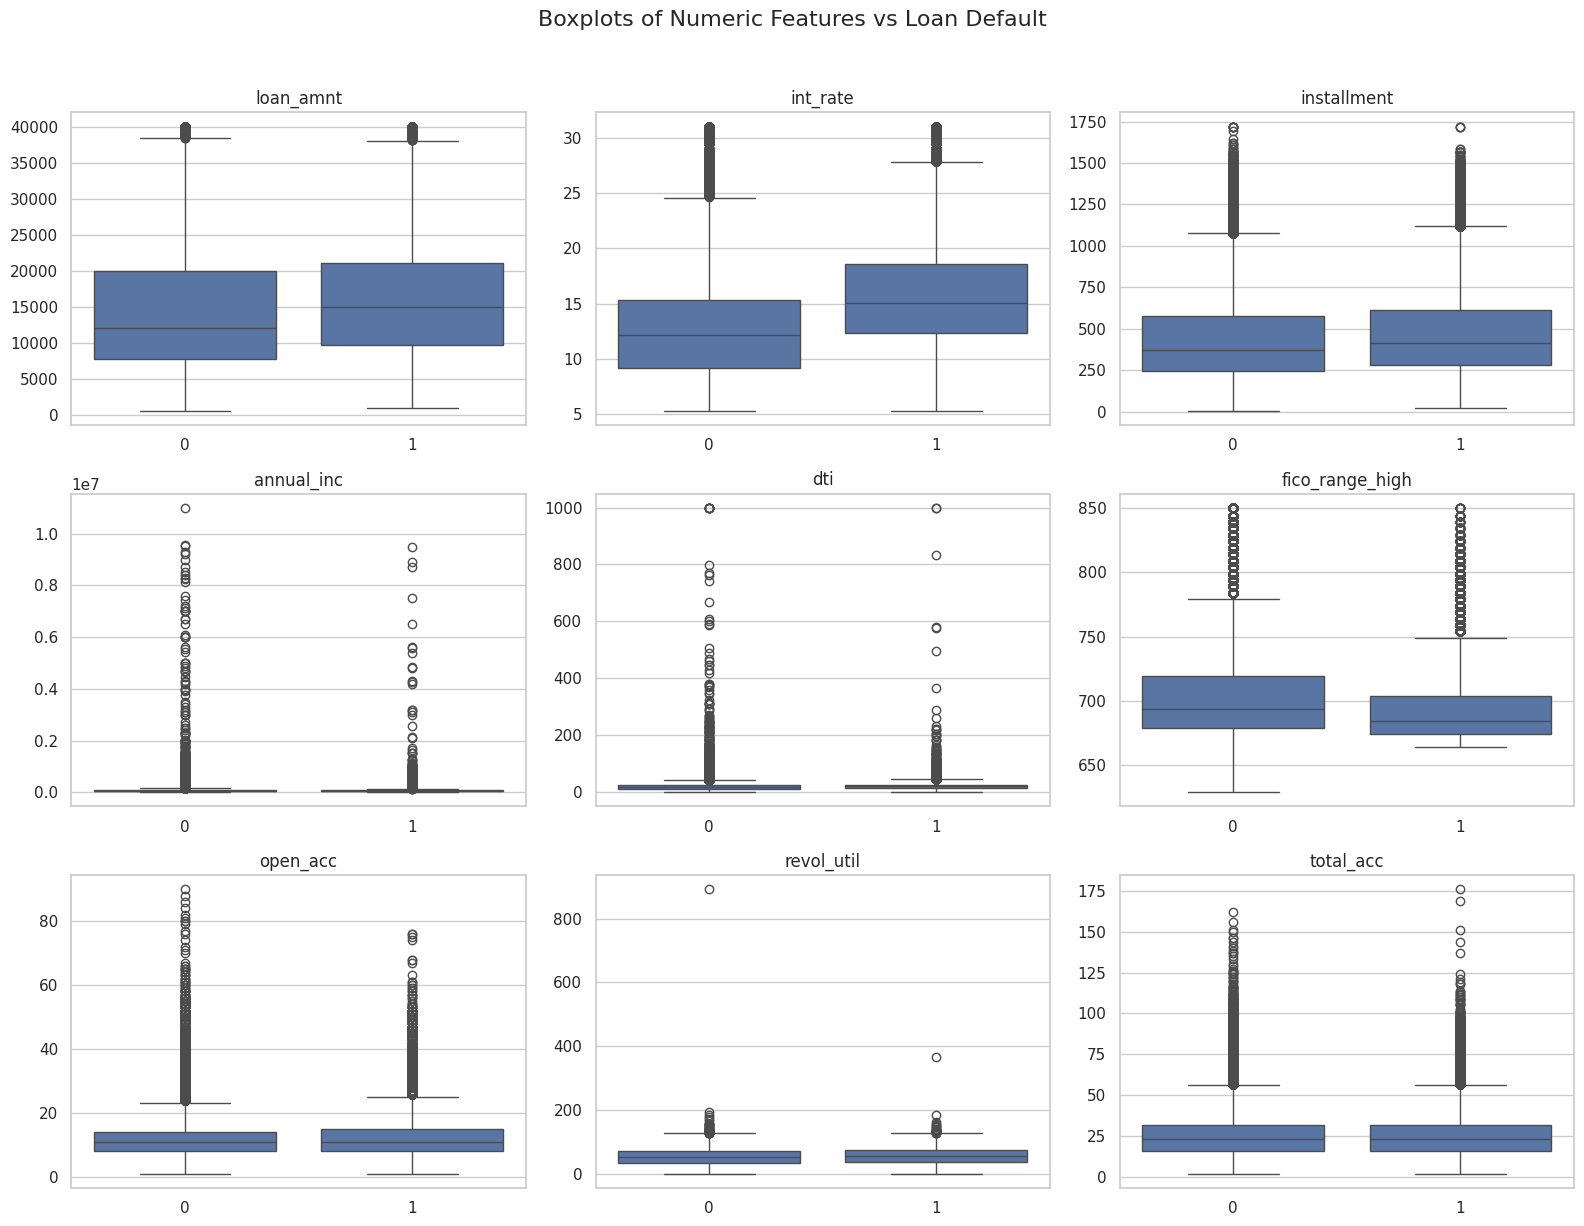

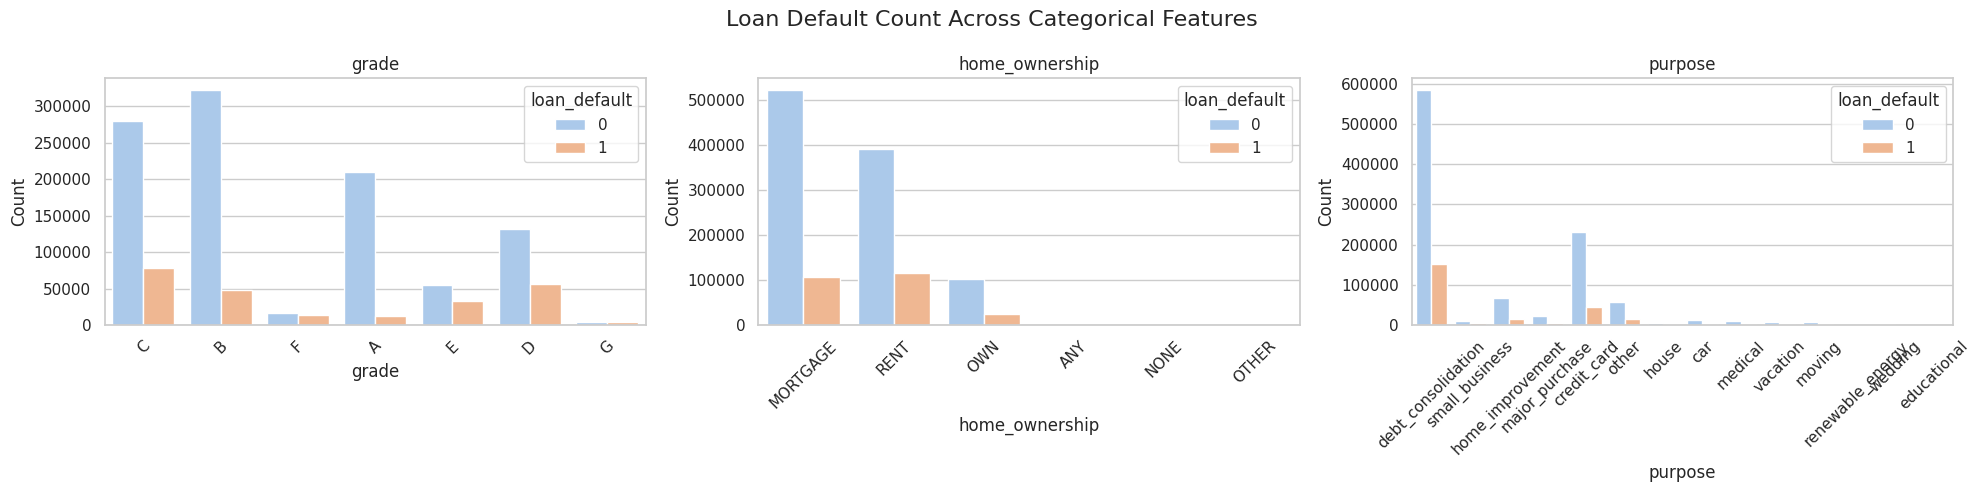

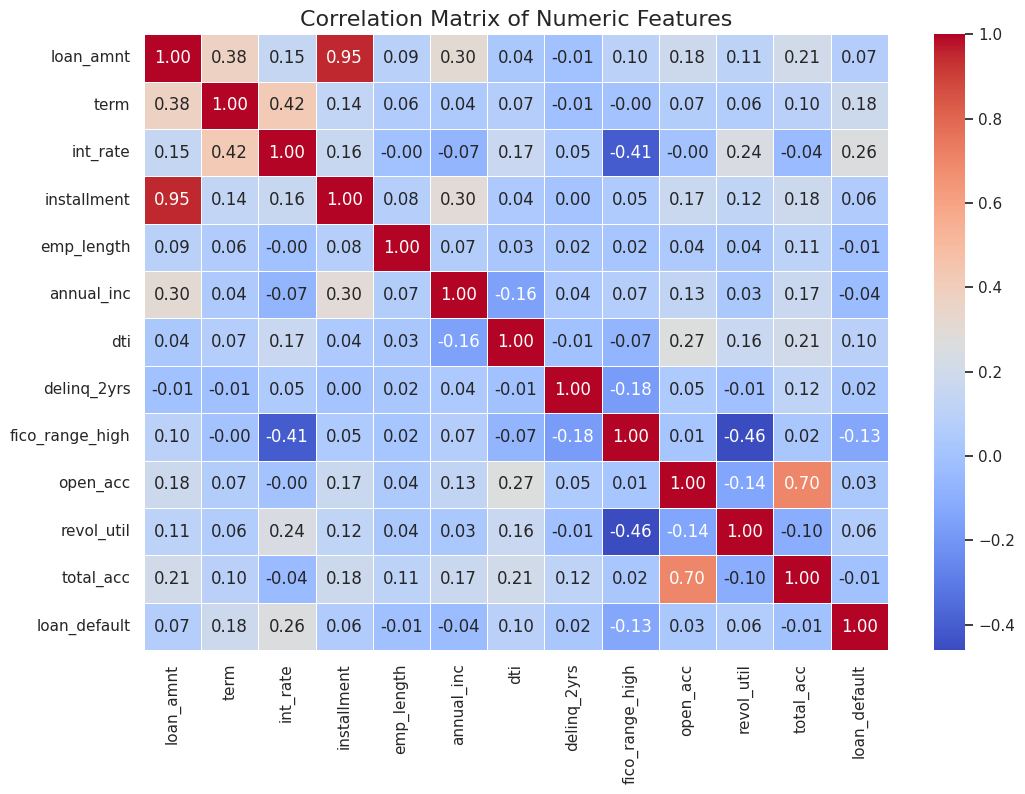

In [28]:
# Boxplots: Visualizing how numerical features differ between defaulted and non-defaulted loans
# This helps identify which continuous variables might be predictive of default risk
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
            'fico_range_high', 'open_acc', 'revol_util', 'total_acc']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Boxplots of Numeric Features vs Loan Default', fontsize=16, y=1.02)

for i, col in enumerate(num_cols):
    r, c = divmod(i, 3)
    sns.boxplot(x='loan_default', y=col, data=df, ax=axes[r][c])
    axes[r][c].set_title(col)
    axes[r][c].set_xlabel('')
    axes[r][c].set_ylabel('')

plt.tight_layout()
plt.show()

# Countplots: Exploring how loan default rates vary across key categorical features
# Useful for spotting patterns like default-prone grades or ownership types
cat_cols = ['grade', 'home_ownership', 'purpose']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Loan Default Count Across Categorical Features', fontsize=16)

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='loan_default', data=df, ax=axes[i], palette='pastel')
    axes[i].set_title(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap: Checking how numerical variables relate to each other
# Especially helpful to spot multicollinearity or strong predictors of default
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

## **Fitting the Baseline model (Logistic Regression)**

In [29]:
# One-hot encode categorical variables so logistic regression can use them
# I drop the first level to avoid multicollinearity
df_encoded = pd.get_dummies(df, drop_first=True)

# Define feature matrix (X) and target (y)
X = df_encoded.drop('loan_default', axis=1).copy()
y = df_encoded['loan_default'].copy()

# Make sure everything is numeric and aligned
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X = X.dropna()
y = y.loc[X.index]

# Add intercept manually for statsmodels
X['intercept'] = 1.0

# Convert to NumPy arrays for statsmodels compatibility
X_np = X.astype(np.float64).values
y_np = y.astype(np.float64).values

# Train logistic regression model on full dataset
logit_model = sm.Logit(y_np, X_np)
result = logit_model.fit()

# Review model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.449055
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1265976
Model:                          Logit   Df Residuals:                  1265939
Method:                           MLE   Df Model:                           36
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                 0.09068
Time:                        16:41:46   Log-Likelihood:            -5.6849e+05
converged:                       True   LL-Null:                   -6.2518e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.863e-05   1.89e-06     -9.837      0.000   -2.23e-05   -1.49e-05
x2             0.0297      0.

Handling Class Imbalance

In [30]:
# The dataset is highly imbalanced, so I apply random undersampling
# This balances the number of defaulted (1) and non-defaulted (0) loans

df_majority = df_encoded[df_encoded['loan_default'] == 0]
df_minority = df_encoded[df_encoded['loan_default'] == 1]

# Downsample majority class to the same size as the minority class
df_majority_down = resample(df_majority,
                            replace=False,
                            n_samples=len(df_minority),
                            random_state=42)

# Combine the downsampled majority with the full minority class
df_balanced = pd.concat([df_majority_down, df_minority])

# Redefine X and y for the balanced dataset
X_bal = df_balanced.drop('loan_default', axis=1)
y_bal = df_balanced['loan_default']

# Add intercept term
X_bal['intercept'] = 1.0

# Convert to float64 NumPy arrays
X_bal_np = X_bal.astype(np.float64).values
y_bal_np = y_bal.astype(np.float64).values

# Train logistic regression model on balanced data
logit_model_bal = sm.Logit(y_bal_np, X_bal_np)
result_bal = logit_model_bal.fit()

# Review the balanced model summary
print(result_bal.summary())

Optimization terminated successfully.
         Current function value: 0.621607
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               494520
Model:                          Logit   Df Residuals:                   494483
Method:                           MLE   Df Model:                           36
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                  0.1032
Time:                        16:42:45   Log-Likelihood:            -3.0740e+05
converged:                       True   LL-Null:                   -3.4278e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.724e-05   2.57e-06     -6.707      0.000   -2.23e-05   -1.22e-05
x2             0.0295      0.

## **Model Evaluation**

Confusion Matrix:
[[1007722   10994]
 [ 233869   13391]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8116    0.9892    0.8917   1018716
         1.0     0.5491    0.0542    0.0986    247260

    accuracy                         0.8066   1265976
   macro avg     0.6804    0.5217    0.4951   1265976
weighted avg     0.7604    0.8066    0.7368   1265976



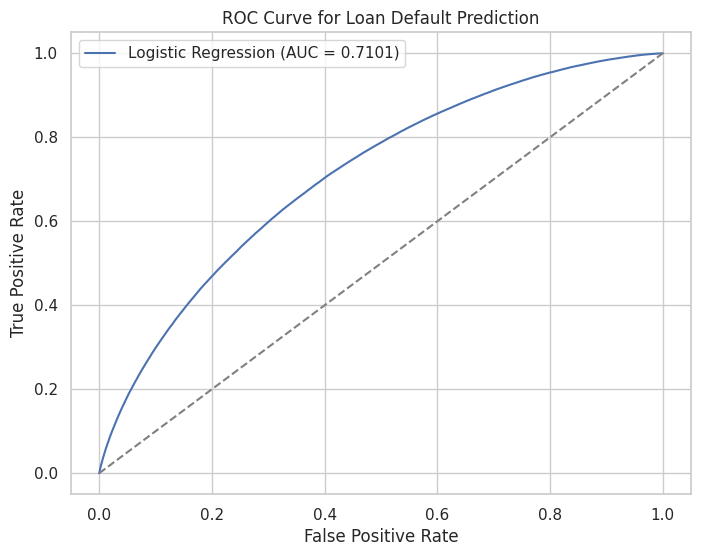

In [31]:
# Predict probabilities of default using the full model
y_prob = result.predict(X_np)

# Convert probabilities to binary predictions using threshold = 0.5
y_pred = (y_prob >= 0.5).astype(int)

# Confusion matrix helps me see false positives and false negatives
print("Confusion Matrix:")
print(confusion_matrix(y_np, y_pred))

# Classification report shows precision, recall, F1-score
print("\nClassification Report:")
print(classification_report(y_np, y_pred, digits=4))

# ROC curve evaluates model’s ability to distinguish between classes
fpr, tpr, thresholds = roc_curve(y_np, y_prob)
auc_score = roc_auc_score(y_np, y_prob)

# Visualize ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Default Prediction')
plt.legend()
plt.grid(True)
plt.show()

## **Downsampled ROC-AUC Plot**

Confusion Matrix (Balanced):
[[156418  90842]
 [ 81361 165899]]

Classification Report (Balanced):
              precision    recall  f1-score   support

         0.0     0.6578    0.6326    0.6450    247260
         1.0     0.6462    0.6709    0.6583    247260

    accuracy                         0.6518    494520
   macro avg     0.6520    0.6518    0.6516    494520
weighted avg     0.6520    0.6518    0.6516    494520



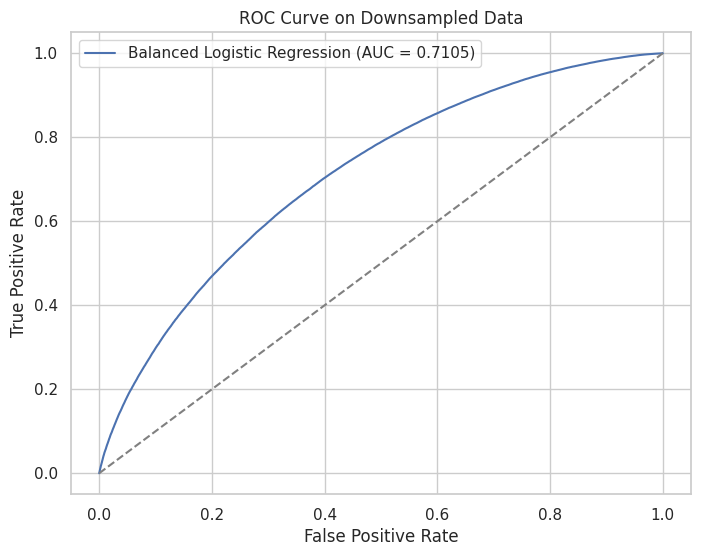

In [32]:
# Balanced model predictions and evaluation
y_prob_bal = result_bal.predict(X_bal_np)
y_pred_bal = (y_prob_bal >= 0.5).astype(int)

# Confusion Matrix & Classification Report
print("Confusion Matrix (Balanced):")
print(confusion_matrix(y_bal_np, y_pred_bal))
print("\nClassification Report (Balanced):")
print(classification_report(y_bal_np, y_pred_bal, digits=4))

# ROC Curve
fpr_bal, tpr_bal, _ = roc_curve(y_bal_np, y_prob_bal)
auc_score_bal = roc_auc_score(y_bal_np, y_prob_bal)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bal, tpr_bal, label=f'Balanced Logistic Regression (AUC = {auc_score_bal:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Downsampled Data')
plt.legend()
plt.grid(True)
plt.show()